In [1]:
% cd ../
! cp -r '/content/drive/My Drive/image/dataset_sieuAmTim14032020.tar.gz' '/content/'

/


In [2]:
%cd content/
! tar -zxvf dataset_sieuAmTim14032020.tar.gz

Streaming output truncated to the last 5000 lines.
dataset/training_set/4C/GEMS_IMG__2013_JUN__11__WV134500__F8HFSS4A_25.jpg
dataset/training_set/4C/GEMS_IMG__2014_DEC__16__PC123304__F8HB5T0S_4.jpg
dataset/training_set/4C/VNHospital__EHospital__20191126__1.2.840.113663.1500.1.428468407.1.1.20191120.144334.425__IM_0328_94.jpg
dataset/training_set/4C/GEMS_IMG__2015_APR__29__WK113923__F8HB0KD8_31.jpg
dataset/training_set/4C/VNHospital__EHospital__20191126__1.2.840.113663.1500.1.428468407.1.1.20191120.153849.486__IM_0391_44.jpg
dataset/training_set/4C/From40Frs__NGUYEN VAN TOAN 53T__4C__IMG-0005-00001.dcm_46.jpg
dataset/training_set/4C/From20Frs__MINH64 HSTC HCM apex EF N__4C__IMG-0110-00001.dcm_36.jpg
dataset/training_set/4C/GEMS_IMG__2010_NOV__08__GP212407__F8HD28A2_6.jpg
dataset/training_set/4C/From20Frs__PHAM THI LUAN L3 ARTIFICIAL MV EF N MISSING 3C__4C__IMG-0191-00001.dcm_37.jpg
dataset/training_set/4C/VNHospital__EHospital__20191126__1.2.840.113663.1500.1.428468407.1.1.20191120.1538

Text(0.5, 1.0, '2')

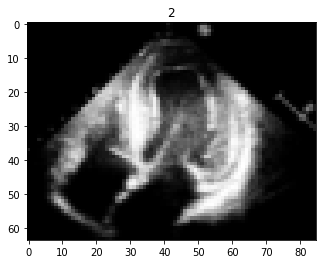

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import nn

from collections import OrderedDict


transform = transforms.Compose([transforms.Resize((80,120)),
                                transforms.CenterCrop((64,85)),
                                transforms.Grayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize( [0.5], [0.5])])


training_dataset = datasets.ImageFolder(root='dataset/training_set',transform=transform)
validation_dataset = datasets.ImageFolder(root='dataset/test_set',transform=transform)

training_loader =  torch.utils.data.DataLoader(dataset=training_dataset,  batch_size=100, shuffle=True,drop_last=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,  batch_size=100, shuffle=True, drop_last=True)


data_iter = iter(training_loader)
images, labels = data_iter.next()

im = images[0][0]
plt.imshow(im,cmap='gray')
plt.title(labels[0].item())

In [0]:
class Classifier(nn.Module):
  def __init__(self, D_in, H1, H2, D_out): # nn with 2 hidden layers
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)
  
  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x


In [5]:
model = Classifier(5440, 1000, 50, 3)
model

Classifier(
  (linear1): Linear(in_features=5440, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=3, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [8]:
epochs = 20
running_loss_his = []
running_corrects_his = []
val_running_loss_his = []
val_running_corrects_his = []
for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss =0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1) # flatten 28x28 -> 784
    # print('input shape: ', inputs.shape) -> 100 784
    outputs = model(inputs)
    loss = criterion(outputs, labels) 

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    # print('running_corrects = ', running_corrects)
    running_loss += loss.item()

  else:
    with torch.no_grad(): # bcz this the val set, no need to cal grad() here
      for val_inputs , val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        _, val_preds = torch.max(val_outputs, 1)
      
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
        # print('val_running_corrects = ', val_running_corrects)

    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    running_loss_his.append(epoch_loss)
    running_corrects_his.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)
    # print('val_running_corrects = ', val_running_corrects)
    # print('length_val_loader = ', len(validation_loader))
    val_running_loss_his.append(val_epoch_loss)
    val_running_corrects_his.append(val_epoch_acc)

    print('epoch ', e, '   training loss: ', epoch_loss, '      acc: ', epoch_acc.item())
    print('epoch ', e, '   validation loss: ', val_epoch_loss, '      acc: ', val_epoch_acc.item())

    state = OrderedDict([
        ('state_dict', model.state_dict()),
        ('optimizer', optimizer.state_dict()),
        ('epoch', e),
        ('accuracy', val_epoch_acc),
    ])
    torch.save(state, '/content/drive/My Drive/image/result_0/model.pth')
    


epoch  0    training loss:  1.3396743337313335       acc:  66.31818389892578
epoch  0    validation loss:  0.6217974312603474       acc:  67.5625
epoch  1    training loss:  1.0456366764776635       acc:  74.57575988769531
epoch  1    validation loss:  0.6039390992373228       acc:  74.9375
epoch  2    training loss:  0.909856733047601       acc:  79.56060791015625
epoch  2    validation loss:  0.399494344368577       acc:  84.1875
epoch  3    training loss:  0.9713051282998287       acc:  78.74242401123047
epoch  3    validation loss:  0.400780625641346       acc:  83.3125
epoch  4    training loss:  0.6261130259795622       acc:  88.51515197753906
epoch  4    validation loss:  0.2430336680263281       acc:  94.1875
epoch  5    training loss:  0.49219436085585394       acc:  91.6515121459961
epoch  5    validation loss:  0.2506035463884473       acc:  90.75
epoch  6    training loss:  0.33281537055066135       acc:  95.01515197753906
epoch  6    validation loss:  0.09987451997585595  

KeyboardInterrupt: ignored